#  Import Libraries and Configure Environment

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go  # For interactive plots

# Technical analysis indicators from the 'ta' library
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# Statistical model for time series forecasting
from statsmodels.tsa.arima.model import ARIMA

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Neural network model and layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Amazon SageMaker for DeepAR model
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer

# Warning management to suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\USER\AppData\Local\sagemaker\sagemaker\config.yaml


# Data Loading and Initial Exploration

In [2]:
# Load the dataset from a CSV file
df = pd.read_csv("ETH-BTC-USD.csv")

# Displaying the first and last few records to understand data structure
print("First five records of the dataset:")
display(df.head())

First five records of the dataset:


Date        Open        High         Low       Close   Adj Close  \
0  11/14/2018  206.533997  207.044998  174.084000  181.397003  181.397003   
1  11/15/2018  181.899002  184.251007  170.188995  180.806000  180.806000   
2  11/16/2018  180.865005  181.350006  173.126007  175.177002  175.177002   
3  11/17/2018  175.360001  175.850998  172.869003  174.001007  174.001007   
4  11/18/2018  174.175003  179.151993  174.175003  177.067001  177.067001   

         Volume  Currency  
0  2.595330e+09  Etherium  
1  2.638410e+09  Etherium  
2  2.015330e+09  Etherium  
3  1.832800e+09  Etherium  
4  1.810920e+09  Etherium

In [3]:
print("Last five records of the dataset:")
display(df.tail())

Last five records of the dataset:


Date         Open         High          Low        Close  \
3649  11/10/2023  36702.25000  37493.80078  36362.75391  37313.96875   
3650  11/11/2023  37310.07031  37407.09375  36773.66797  37138.05078   
3651  11/12/2023  37133.99219  37227.69141  36779.11719  37054.51953   
3652  11/13/2023  37070.30469  37405.11719  36399.60547  36502.35547   
3653  11/14/2023  36491.78906  36743.07031  36240.79688  36702.21484   

        Adj Close        Volume Currency  
3649  37313.96875  2.271127e+10  Bitcoin  
3650  37138.05078  1.392427e+10  Bitcoin  
3651  37054.51953  1.154572e+10  Bitcoin  
3652  36502.35547  1.905771e+10  Bitcoin  
3653  36702.21484  1.838954e+10  Bitcoin

In [4]:
# Checking for missing values to ensure data integrity
missing_values = df.isna().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Currency     0
dtype: int64


In [5]:
# Displaying a brief statistical summary to get an overview of numerical features
print("Statistical summary of the dataset:")
display(df.describe())

Statistical summary of the dataset:


Open          High           Low         Close     Adj Close  \
count   3654.000000   3654.000000   3654.000000   3654.000000   3654.000000   
mean   12489.722362  12779.702503  12176.712024  12497.298504  12497.298504   
std    15981.149824  16367.131613  15548.523408  15982.555689  15982.555689   
min       84.279694     85.342743     82.829887     84.308296     84.308296   
25%     1318.626008   1346.194641   1275.408967   1320.796630   1320.796630   
50%     3880.535767   3964.966553   3783.871582   3881.728149   3881.728149   
75%    20589.010253  21038.371580  20185.608885  20598.490722  20598.490722   
max    67549.734380  68789.625000  66382.062500  67566.828130  67566.828130   

             Volume  
count  3.654000e+03  
mean   2.132673e+10  
std    1.657009e+10  
min    1.496177e+09  
25%    9.610954e+09  
50%    1.741543e+10  
75%    2.857312e+10  
max    3.509680e+11

# Data Filtering and Plotting for Bitcoin and Ethereum

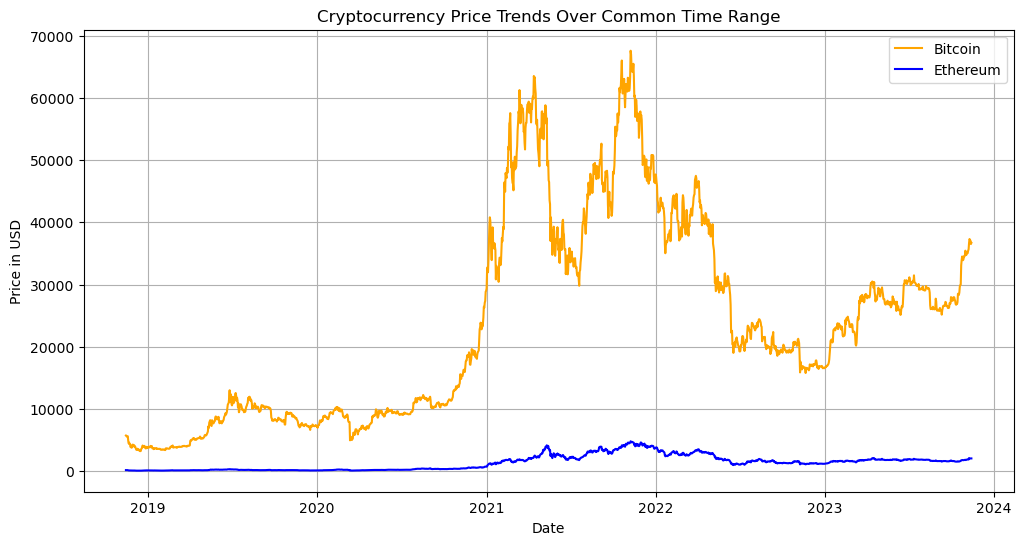

In [10]:
# Correcting any potential typo in the 'Currency' label
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Separate the data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Ethereum']

# Convert 'Date' columns to datetime format for accurate merging and plotting
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
ethereum_data['Date'] = pd.to_datetime(ethereum_data['Date'])

# Finding the common date range
common_dates = pd.merge(bitcoin_data[['Date']], ethereum_data[['Date']], how='inner', on='Date').drop_duplicates()

# Filtering data to only include common dates
bitcoin_data_common = bitcoin_data[bitcoin_data['Date'].isin(common_dates['Date'])]
ethereum_data_common = ethereum_data[ethereum_data['Date'].isin(common_dates['Date'])]

# Check if data is present and plot
if not bitcoin_data_common.empty and not ethereum_data_common.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(bitcoin_data_common['Date'], bitcoin_data_common['Close'], label='Bitcoin', color='orange')
    plt.plot(ethereum_data_common['Date'], ethereum_data_common['Close'], label='Ethereum', color='blue')
    plt.title('Cryptocurrency Price Trends Over Common Time Range')
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No common data points to plot.")


# Creating Combined Candlestick Charts for Bitcoin and Ethereum

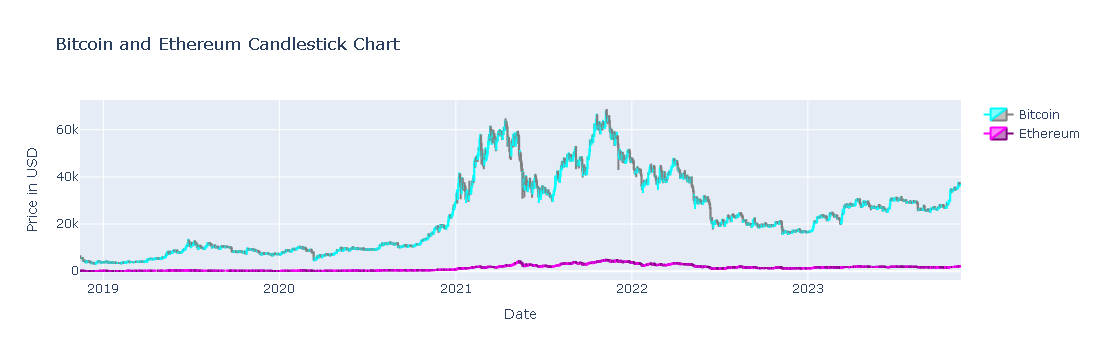

In [15]:
# Correcting any potential typo in the 'Currency' label for consistency
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Creating a candlestick chart for Bitcoin with distinct color scheme for clarity
bitcoin_data = df[df['Currency'] == 'Bitcoin']
fig = go.Figure(data=[go.Candlestick(x=bitcoin_data['Date'],
                                     open=bitcoin_data['Open'],
                                     high=bitcoin_data['High'],
                                     low=bitcoin_data['Low'],
                                     close=bitcoin_data['Close'],
                                     name='Bitcoin',
                                     increasing_line_color='cyan', decreasing_line_color='gray')])

# Adding a candlestick chart for Ethereum with a contrasting color palette
ethereum_data = df[df['Currency'] == 'Ethereum']
fig.add_trace(go.Candlestick(x=ethereum_data['Date'],
                             open=ethereum_data['Open'],
                             high=ethereum_data['High'],
                             low=ethereum_data['Low'],
                             close=ethereum_data['Close'],
                             name='Ethereum',
                             increasing_line_color='magenta', decreasing_line_color='purple'))

# Updating the layout to enhance readability and visual appeal
fig.update_layout(title='Bitcoin and Ethereum Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price in USD',
                  xaxis_rangeslider_visible=False # Disabling range slider for a cleaner look
                 ) 

fig.show()


# Histograms for Bitcoin and Ethereum Trading Volume

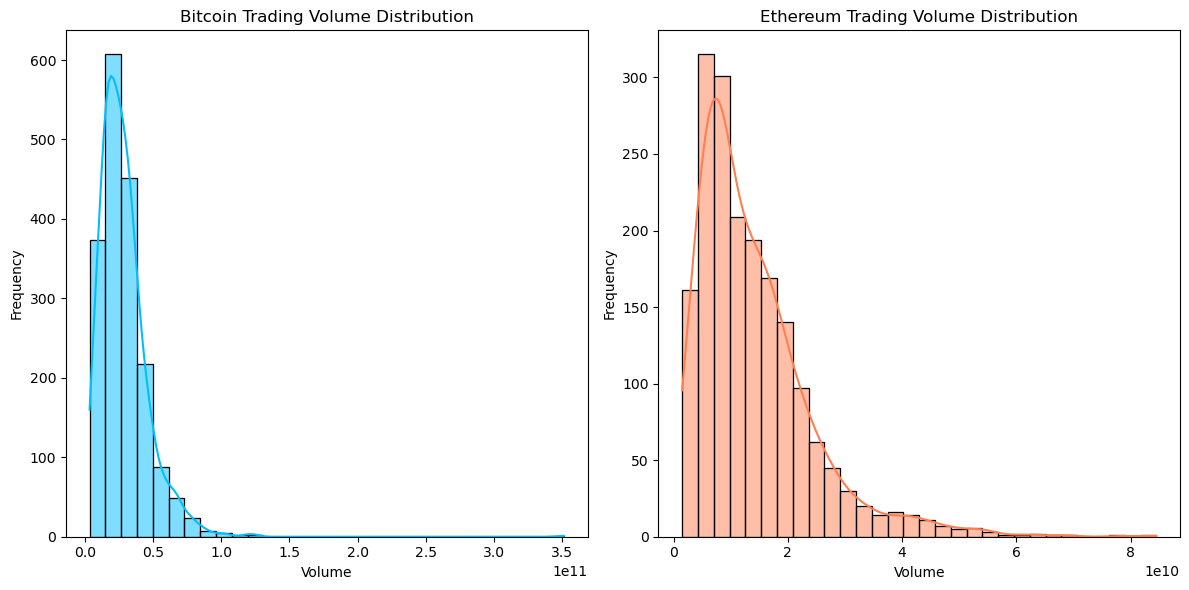

In [14]:
# Correcting any potential typo in the 'Currency' label for consistency
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Separating data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Ethereum']

# Setting up the figure with subplots
plt.figure(figsize=(12, 6))

# Plotting histogram for Bitcoin trading volume with color optimization
plt.subplot(1, 2, 1)
sns.histplot(bitcoin_data['Volume'], bins=30, kde=True, color='deepskyblue')
plt.title('Bitcoin Trading Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# Plotting histogram for Ethereum trading volume with a contrasting color
plt.subplot(1, 2, 2)
sns.histplot(ethereum_data['Volume'], bins=30, kde=True, color='coral')
plt.title('Ethereum Trading Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# Adjusting layout for better visualization and to avoid overlap
plt.tight_layout()

# Displaying the plots
plt.show()


# Box Plots for Bitcoin and Ethereum Trading Volume

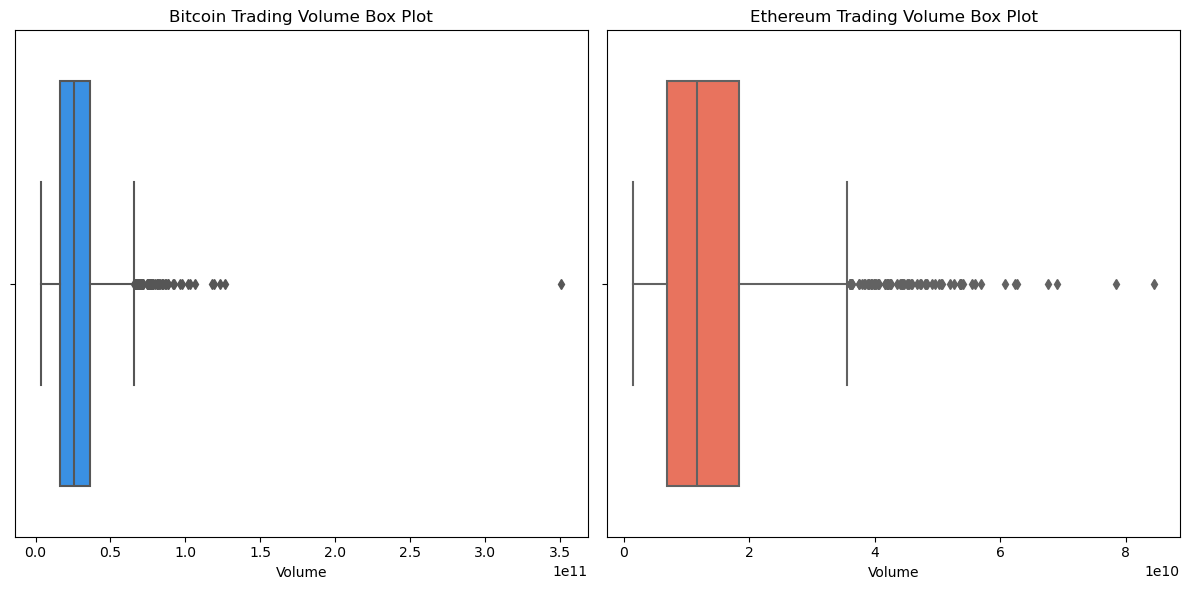

In [16]:
# Correcting any potential typo in the 'Currency' label for consistency
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Separating data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Ethereum']

# Setting up the figure with subplots for a side-by-side comparison
plt.figure(figsize=(12, 6))

# Creating a box plot for Bitcoin trading volume with a visually appealing color
plt.subplot(1, 2, 1)
sns.boxplot(x=bitcoin_data['Volume'], color='dodgerblue')
plt.title('Bitcoin Trading Volume Box Plot')
plt.xlabel('Volume')

# Creating a box plot for Ethereum trading volume with a contrasting color
plt.subplot(1, 2, 2)
sns.boxplot(x=ethereum_data['Volume'], color='tomato')
plt.title('Ethereum Trading Volume Box Plot')
plt.xlabel('Volume')

# Adjusting layout for better visualization and clarity
plt.tight_layout()

# Displaying the plots
plt.show()


# Outlier Detection for Bitcoin and Ethereum Trading Volume

In [17]:
# Correcting any potential typo in the 'Currency' label for consistency
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Calculating the Interquartile Range (IQR) for Bitcoin trading volume
bitcoin_volume_iqr = bitcoin_data['Volume'].quantile(0.75) - bitcoin_data['Volume'].quantile(0.25)
bitcoin_volume_upper_bound = bitcoin_data['Volume'].quantile(0.75) + 1.5 * bitcoin_volume_iqr

# Identifying outliers in Bitcoin trading volume that exceed the upper bound
bitcoin_outliers = bitcoin_data[bitcoin_data['Volume'] > bitcoin_volume_upper_bound]

# Calculating the IQR for Ethereum trading volume
ethereum_volume_iqr = ethereum_data['Volume'].quantile(0.75) - ethereum_data['Volume'].quantile(0.25)
ethereum_volume_upper_bound = ethereum_data['Volume'].quantile(0.75) + 1.5 * ethereum_volume_iqr

# Identifying outliers in Ethereum trading volume that exceed the upper bound
ethereum_outliers = ethereum_data[ethereum_data['Volume'] > ethereum_volume_upper_bound]

# Printing the outliers for Bitcoin
print("Bitcoin Outliers:")
print(bitcoin_outliers)

# Printing the outliers for Ethereum
print("\nEthereum Outliers:")
print(ethereum_outliers)


Bitcoin Outliers:
           Date          Open          High           Low         Close  \
2312 2020-03-13   5017.831055   5838.114746   4106.980957   5563.707031   
2360 2020-04-30   8797.669922   9440.650391   8533.255859   8658.553711   
2517 2020-10-04  10550.440430  10686.000000  10534.391600  10669.583010   
2591 2020-12-17  21308.351560  23642.660160  21234.675780  22805.162110   
2601 2020-12-27  26439.373050  28288.839840  25922.769530  26272.294920   
...         ...           ...           ...           ...           ...   
3102 2022-05-12  28936.734380  30032.439450  26350.490230  29047.751950   
3134 2022-06-13  26737.578130  26795.589840  22141.257810  22487.388670   
3282 2022-11-08  20600.671880  20664.607420  17603.544920  18541.271480   
3283 2022-11-09  18543.761720  18590.458980  15682.692380  15880.780270   
3284 2022-11-10  15883.158200  18054.312500  15834.018560  17586.771480   

         Adj Close        Volume Currency  
2312   5563.707031  7.415677e+10  Bit

# Visualization of Bitcoin and Ethereum Trading Volumes with Outliers

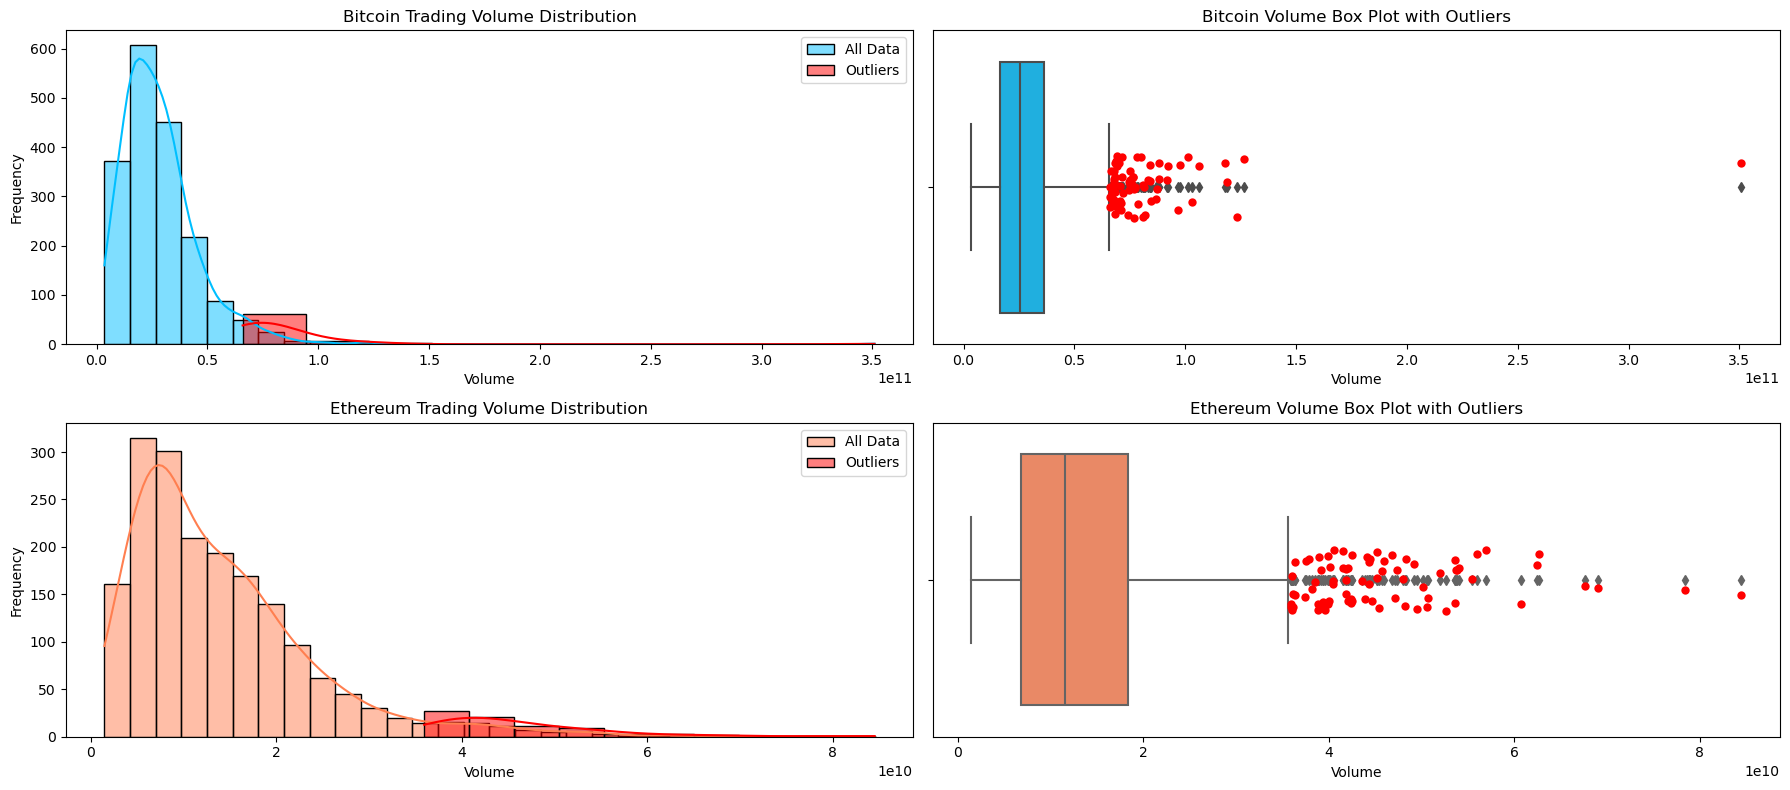

In [18]:
# Set up the figure with subplots for both histogram and box plot visualizations
plt.figure(figsize=(18, 8))

# Histogram and Box Plot for Bitcoin trading volume
plt.subplot(2, 2, 1)
sns.histplot(bitcoin_data['Volume'], bins=30, kde=True, color='deepskyblue', label='All Data')
sns.histplot(bitcoin_outliers['Volume'], bins=10, kde=True, color='red', label='Outliers')
plt.title('Bitcoin Trading Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
sns.boxplot(x=bitcoin_data['Volume'], color='deepskyblue')
sns.stripplot(x=bitcoin_outliers['Volume'], color='red', size=6)
plt.title('Bitcoin Volume Box Plot with Outliers')
plt.xlabel('Volume')

# Histogram and Box Plot for Ethereum trading volume
plt.subplot(2, 2, 3)
sns.histplot(ethereum_data['Volume'], bins=30, kde=True, color='coral', label='All Data')
sns.histplot(ethereum_outliers['Volume'], bins=10, kde=True, color='red', label='Outliers')
plt.title('Ethereum Trading Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 4)
sns.boxplot(x=ethereum_data['Volume'], color='coral')
sns.stripplot(x=ethereum_outliers['Volume'], color='red', size=6)
plt.title('Ethereum Volume Box Plot with Outliers')
plt.xlabel('Volume')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


# Correlation Analysis and Heatmap Visualization for Bitcoin and Ethereum

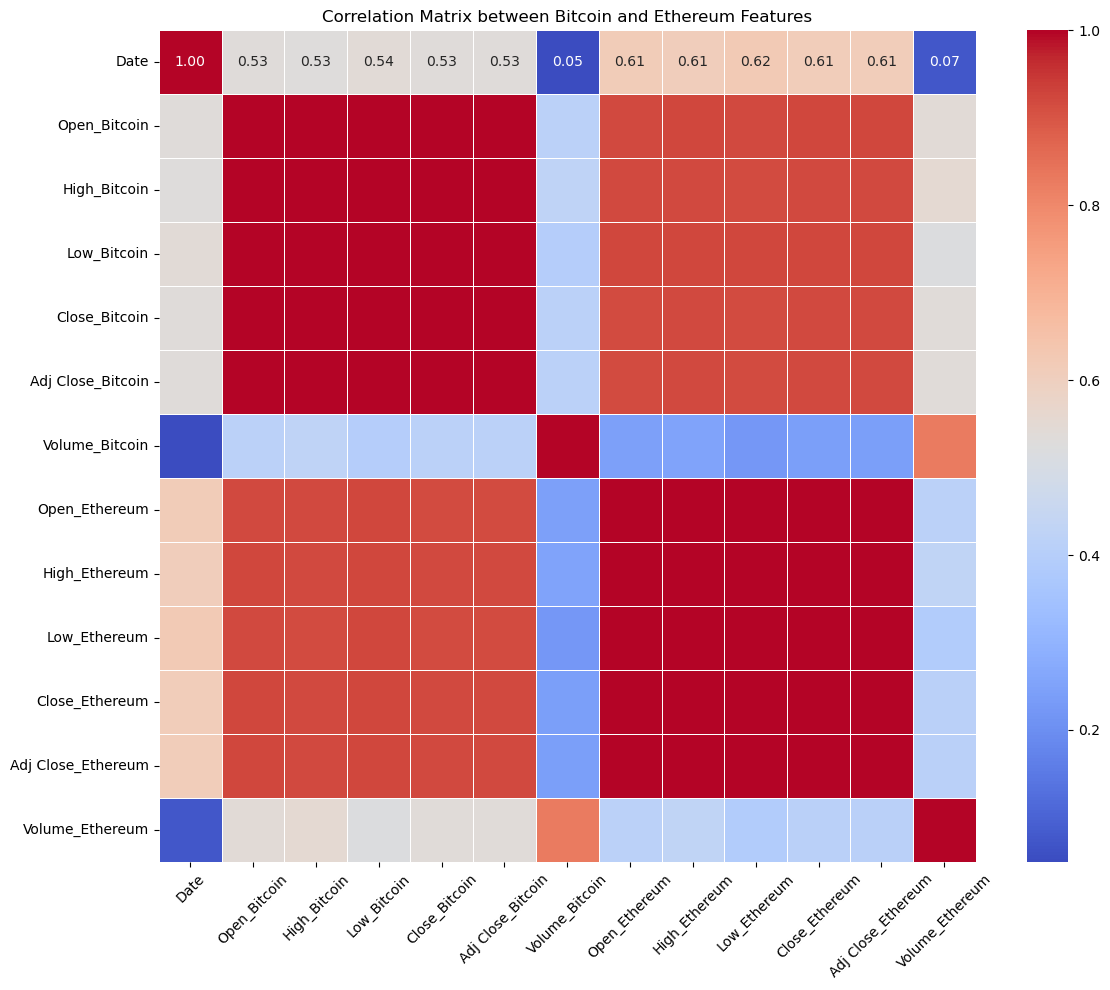

In [19]:
# Correcting any potential typo in the 'Currency' label for consistency
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Separating data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Ethereum']

# Selecting numeric columns excluding 'Currency'
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Merging the two datasets on the 'Date' column for numeric features, ensuring both datasets align properly
merged_data = pd.merge(
    bitcoin_data[['Date'] + numeric_columns], 
    ethereum_data[['Date'] + numeric_columns], 
    on='Date', 
    suffixes=('_Bitcoin', '_Ethereum')
)

# Calculating the correlation matrix for the numeric features of Bitcoin and Ethereum
correlation_matrix = merged_data.corr()

# Visualizing the correlation matrix as a heatmap to enhance readability and understanding
plt.figure(figsize=(12, 10))  # Increased size for better visibility
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Correlation Matrix between Bitcoin and Ethereum Features')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to fit the larger figure size
plt.show()


# Volatility Analysis for Bitcoin and Ethereum with Improved Data Handling

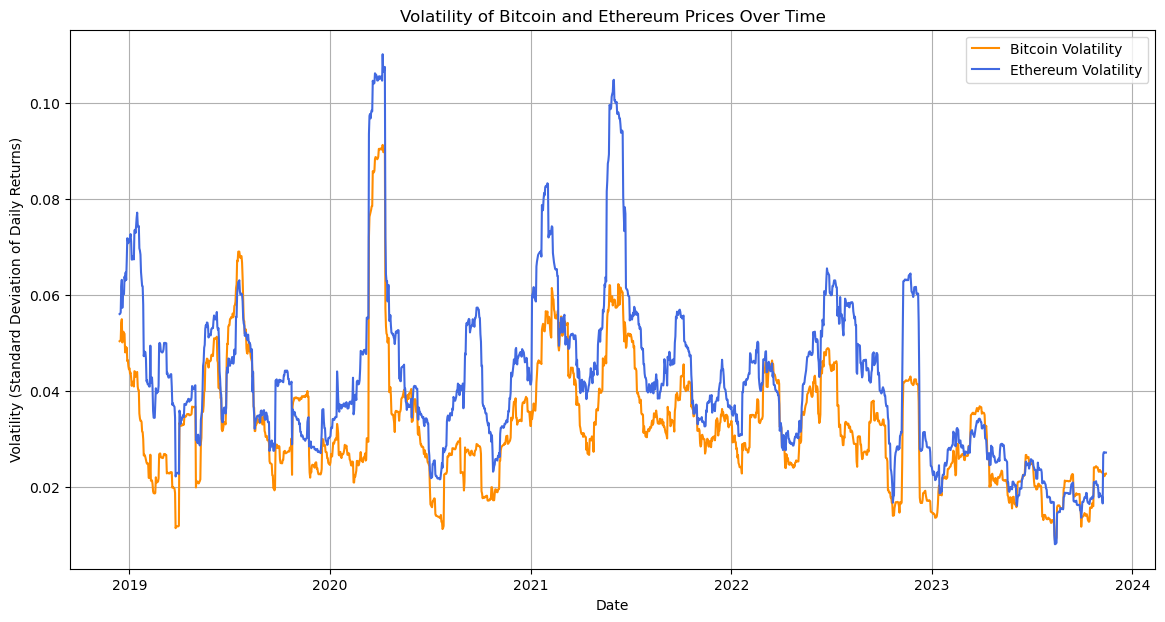

In [20]:
# Correcting any potential typo in the 'Currency' label for consistency
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Separating data for Bitcoin and Ethereum, ensuring accurate data referencing
bitcoin_data = df[df['Currency'] == 'Bitcoin'].copy()
ethereum_data = df[df['Currency'] == 'Ethereum'].copy()

# Ensure 'Date' is in datetime format for plotting
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
ethereum_data['Date'] = pd.to_datetime(ethereum_data['Date'])

# Calculating daily returns for Bitcoin and Ethereum
bitcoin_data['Daily_Return'] = bitcoin_data['Close'].pct_change()
ethereum_data['Daily_Return'] = ethereum_data['Close'].pct_change()

# Calculating the rolling standard deviation (volatility) for a specified window
window_size = 30  # This value can be adjusted based on the desired granularity
bitcoin_volatility = bitcoin_data['Daily_Return'].rolling(window=window_size).std()
ethereum_volatility = ethereum_data['Daily_Return'].rolling(window=window_size).std()

# Plotting the volatility of Bitcoin and Ethereum prices using a line graph for better trend visualization
plt.figure(figsize=(14, 7))  # Adjusted figure size for better visibility
plt.plot(bitcoin_data['Date'], bitcoin_volatility, label='Bitcoin Volatility', color='darkorange')
plt.plot(ethereum_data['Date'], ethereum_volatility, label='Ethereum Volatility', color='royalblue')
plt.title('Volatility of Bitcoin and Ethereum Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation of Daily Returns)')
plt.legend()
plt.grid(True)  # Enhanced grid visibility for easier analysis
plt.show()


# Visualization of Bitcoin and Ethereum Prices with Moving Averages

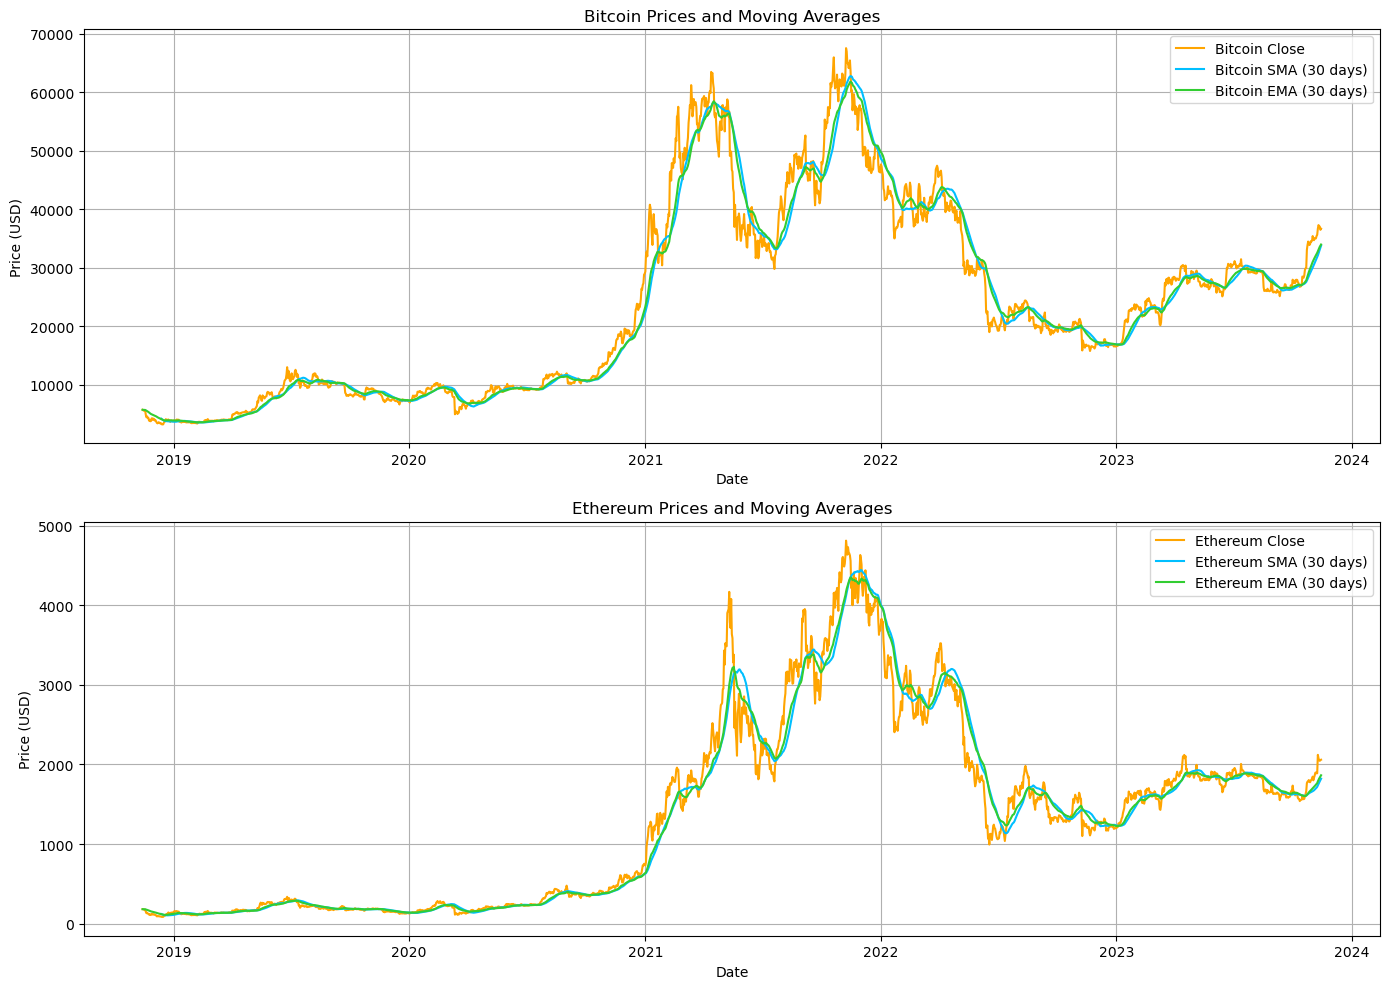

In [21]:
# Correcting any potential typo in the 'Currency' label for consistency
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Separating data for Bitcoin and Ethereum, ensuring accurate data referencing
bitcoin_data = df[df['Currency'] == 'Bitcoin'].copy()
ethereum_data = df[df['Currency'] == 'Ethereum'].copy()

# Ensure 'Date' is in datetime format for accurate plotting
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
ethereum_data['Date'] = pd.to_datetime(ethereum_data['Date'])

# Calculating the simple moving averages (SMA) for both Bitcoin and Ethereum
sma_window = 30  # This window size can be adjusted based on your preference
bitcoin_data['SMA'] = bitcoin_data['Close'].rolling(window=sma_window).mean()
ethereum_data['SMA'] = ethereum_data['Close'].rolling(window=sma_window).mean()

# Calculating the exponential moving averages (EMA) for both cryptocurrencies
ema_window = 30  # This window size can also be adjusted as needed
bitcoin_data['EMA'] = bitcoin_data['Close'].ewm(span=ema_window, adjust=False).mean()
ethereum_data['EMA'] = ethereum_data['Close'].ewm(span=ema_window, adjust=False).mean()

# Plotting the price along with SMA and EMA for Bitcoin
plt.figure(figsize=(14, 10))  # Adjusted figure size for better visibility

plt.subplot(2, 1, 1)
plt.plot(bitcoin_data['Date'], bitcoin_data['Close'], label='Bitcoin Close', color='orange')
plt.plot(bitcoin_data['Date'], bitcoin_data['SMA'], label=f'Bitcoin SMA ({sma_window} days)', color='deepskyblue')
plt.plot(bitcoin_data['Date'], bitcoin_data['EMA'], label=f'Bitcoin EMA ({ema_window} days)', color='limegreen')
plt.title('Bitcoin Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# Plotting the price along with SMA and EMA for Ethereum
plt.subplot(2, 1, 2)
plt.plot(ethereum_data['Date'], ethereum_data['Close'], label='Ethereum Close', color='orange')
plt.plot(ethereum_data['Date'], ethereum_data['SMA'], label=f'Ethereum SMA ({sma_window} days)', color='deepskyblue')
plt.plot(ethereum_data['Date'], ethereum_data['EMA'], label=f'Ethereum EMA ({ema_window} days)', color='limegreen')
plt.title('Ethereum Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjusts layout to fit the plots without overlap
plt.show()


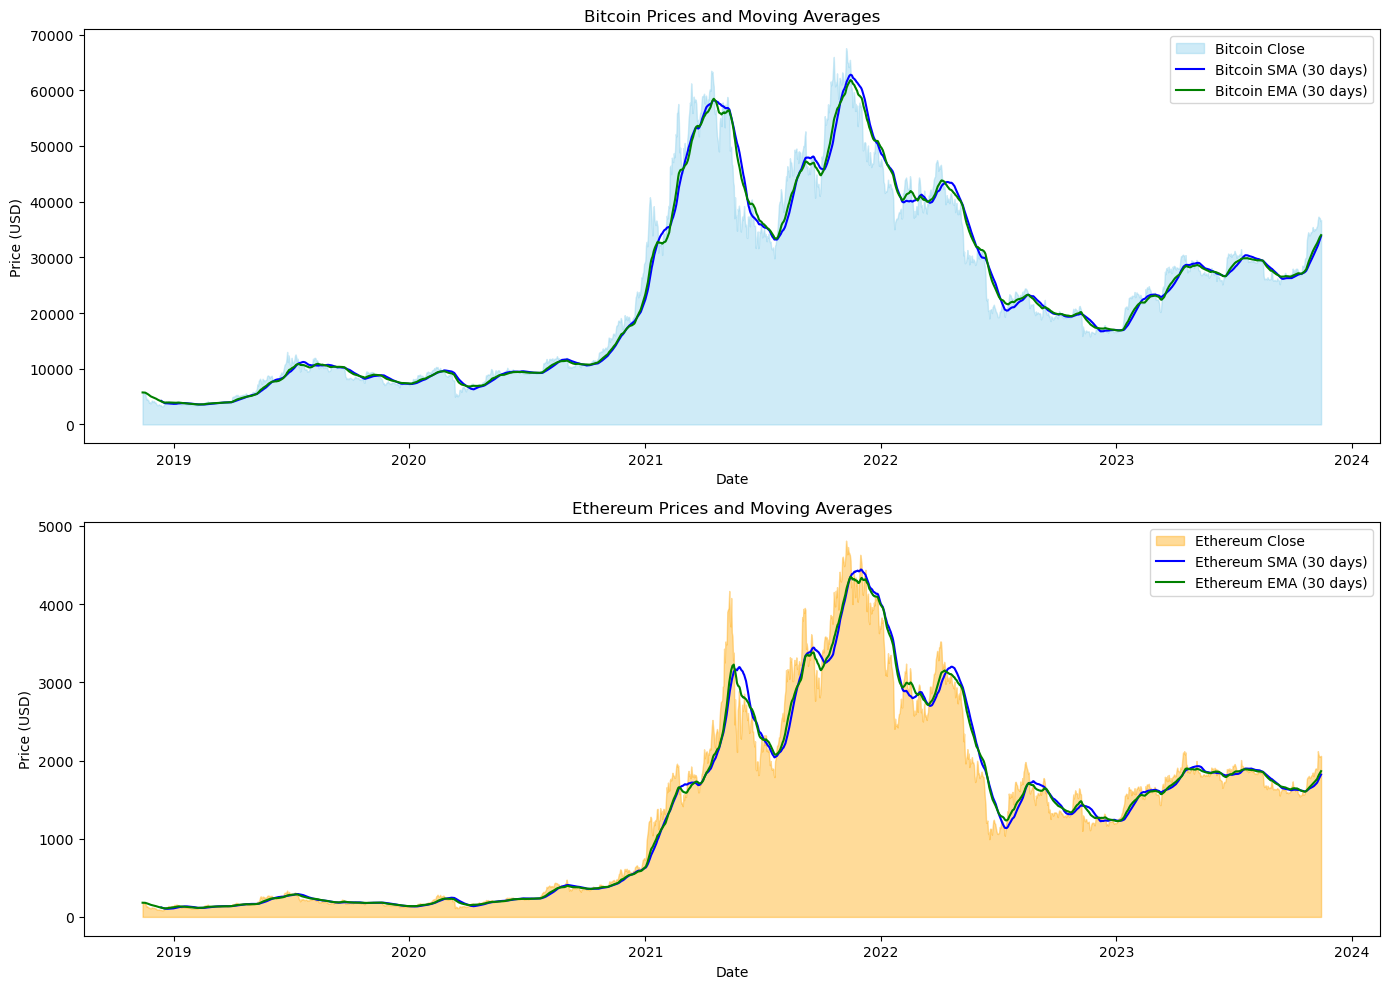

In [22]:
plt.figure(figsize=(14, 10))

# Bitcoin area plot with moving averages
plt.subplot(2, 1, 1)
plt.fill_between(bitcoin_data['Date'], bitcoin_data['Close'], color="skyblue", alpha=0.4, label='Bitcoin Close')
plt.plot(bitcoin_data['Date'], bitcoin_data['SMA'], color='blue', label=f'Bitcoin SMA ({sma_window} days)')
plt.plot(bitcoin_data['Date'], bitcoin_data['EMA'], color='green', label=f'Bitcoin EMA ({ema_window} days)')
plt.title('Bitcoin Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

# Ethereum area plot with moving averages
plt.subplot(2, 1, 2)
plt.fill_between(ethereum_data['Date'], ethereum_data['Close'], color="orange", alpha=0.4, label='Ethereum Close')
plt.plot(ethereum_data['Date'], ethereum_data['SMA'], color='blue', label=f'Ethereum SMA ({sma_window} days)')
plt.plot(ethereum_data['Date'], ethereum_data['EMA'], color='green', label=f'Ethereum EMA ({ema_window} days)')
plt.title('Ethereum Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()


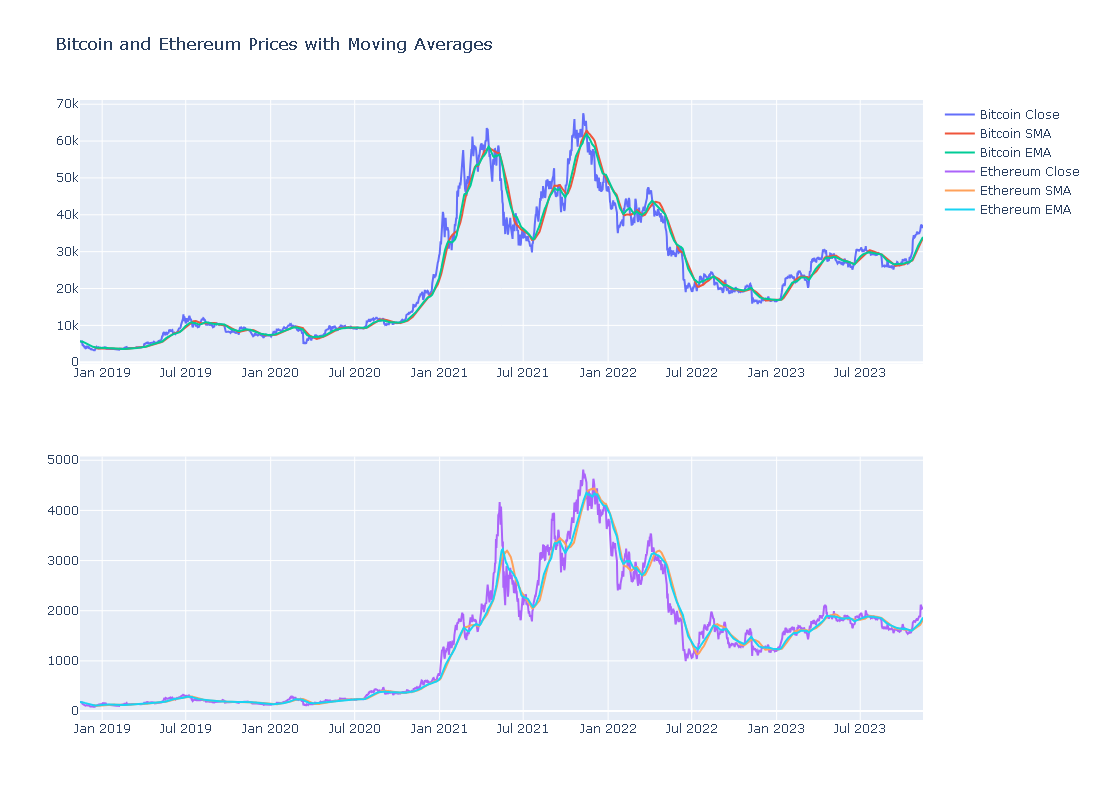

In [24]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1)

# Bitcoin with Plotly
fig.add_trace(go.Scatter(x=bitcoin_data['Date'], y=bitcoin_data['Close'], mode='lines', name='Bitcoin Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=bitcoin_data['Date'], y=bitcoin_data['SMA'], mode='lines', name='Bitcoin SMA'), row=1, col=1)
fig.add_trace(go.Scatter(x=bitcoin_data['Date'], y=bitcoin_data['EMA'], mode='lines', name='Bitcoin EMA'), row=1, col=1)

# Ethereum with Plotly
fig.add_trace(go.Scatter(x=ethereum_data['Date'], y=ethereum_data['Close'], mode='lines', name='Ethereum Close'), row=2, col=1)
fig.add_trace(go.Scatter(x=ethereum_data['Date'], y=ethereum_data['SMA'], mode='lines', name='Ethereum SMA'), row=2, col=1)
fig.add_trace(go.Scatter(x=ethereum_data['Date'], y=ethereum_data['EMA'], mode='lines', name='Ethereum EMA'), row=2, col=1)

fig.update_layout(height=800, width=700, title_text="Bitcoin and Ethereum Prices with Moving Averages")
fig.show()


# Average Monthly Closing Prices of Bitcoin and Ethereum

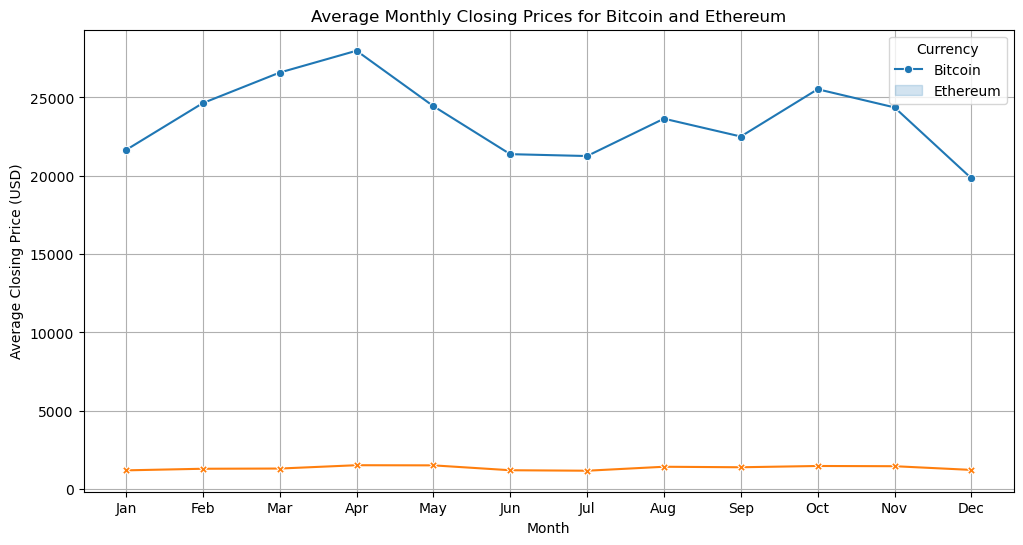

In [27]:
# Assuming 'df' has a 'Date' column in datetime format
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Group by month and calculate the average closing price for each currency
average_monthly_prices = df.groupby(['Month', 'Currency'])['Close'].mean().reset_index()

# Pivot the data for better visualization
pivot_table = average_monthly_prices.pivot(index='Month', columns='Currency', values='Close')

# Plotting the average monthly closing prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_table, markers=True, dashes=False)  # Using markers for each point
plt.title('Average Monthly Closing Prices for Bitcoin and Ethereum')
plt.xlabel('Month')
plt.ylabel('Average Closing Price (USD)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set custom month labels
plt.legend(title='Currency', labels=pivot_table.columns)
plt.grid(True)
plt.show()

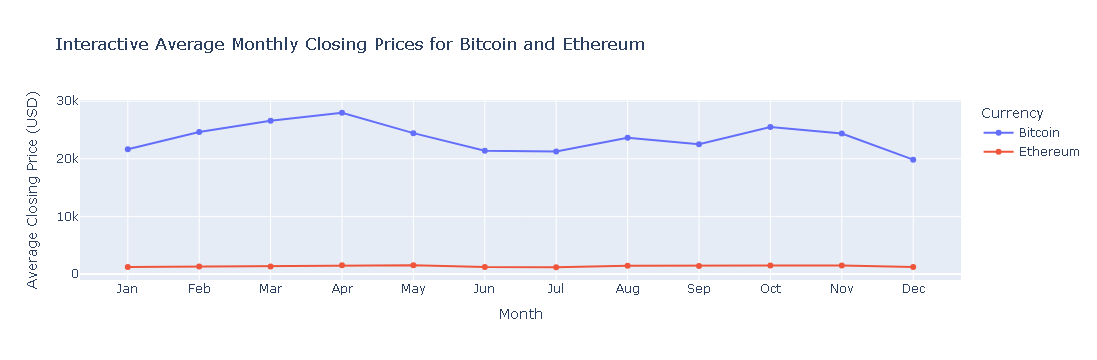

In [34]:
import plotly.express as px
import pandas as pd

# Assuming 'df' has a 'Date' column in datetime format already
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Group by month and calculate the average closing price for each currency
average_monthly_prices = df.groupby(['Month', 'Currency'])['Close'].mean().reset_index()

# Convert 'Month' to month names for better readability in the plot
average_monthly_prices['Month'] = average_monthly_prices['Month'].apply(lambda x: pd.to_datetime(f"{x}", format='%m').strftime('%b'))

# Create an interactive line chart with Plotly Express
fig = px.line(average_monthly_prices, x='Month', y='Close', color='Currency',
              labels={'Close': 'Average Closing Price (USD)', 'Month': 'Month'},
              title='Interactive Average Monthly Closing Prices for Bitcoin and Ethereum',
              markers=True)  # Include markers for data points

# Customize the layout and add customization features
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=[i for i in range(12)],
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    yaxis_title='Average Closing Price (USD)',
    xaxis_title='Month',
    legend_title='Currency'
)

# Show the interactive figure
fig.show()


# Visualization of Bitcoin and Ethereum Prices with Technical Indicators

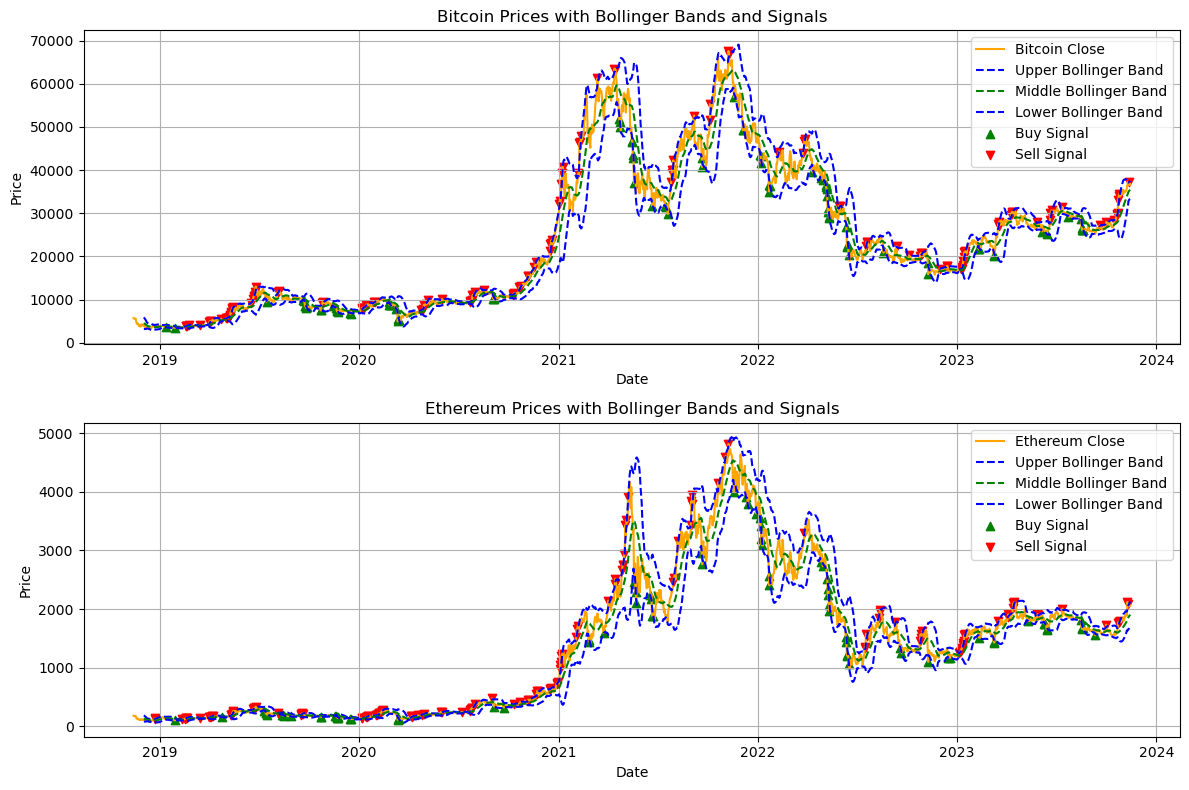

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator

# Correct the spelling of Ethereum in the DataFrame
df['Currency'] = df['Currency'].replace('Etherium', 'Ethereum')

# Separate data for Bitcoin and Ethereum
bitcoin_data = df[df['Currency'] == 'Bitcoin']
ethereum_data = df[df['Currency'] == 'Ethereum']

# Initialize and calculate technical indicators safely
if not bitcoin_data.empty:
    bitcoin_data['macd'] = MACD(bitcoin_data['Close']).macd()
    bitcoin_data['rsi'] = RSIIndicator(bitcoin_data['Close']).rsi()
    bb_bands_bitcoin = BollingerBands(bitcoin_data['Close'])
    bitcoin_data['bb_upper'] = bb_bands_bitcoin.bollinger_hband()
    bitcoin_data['bb_lower'] = bb_bands_bitcoin.bollinger_lband()
    bitcoin_data['bb_mid'] = bb_bands_bitcoin.bollinger_mavg()
    bitcoin_data['Buy_Signal'] = (bitcoin_data['Close'] < bitcoin_data['bb_lower']).astype(int)
    bitcoin_data['Sell_Signal'] = (bitcoin_data['Close'] > bitcoin_data['bb_upper']).astype(int)

if not ethereum_data.empty:
    ethereum_data['macd'] = MACD(ethereum_data['Close']).macd()
    ethereum_data['rsi'] = RSIIndicator(ethereum_data['Close']).rsi()
    bb_bands_ethereum = BollingerBands(ethereum_data['Close'])
    ethereum_data['bb_upper'] = bb_bands_ethereum.bollinger_hband()
    ethereum_data['bb_lower'] = bb_bands_ethereum.bollinger_lband()
    ethereum_data['bb_mid'] = bb_bands_ethereum.bollinger_mavg()
    ethereum_data['Buy_Signal'] = (ethereum_data['Close'] < ethereum_data['bb_lower']).astype(int)
    ethereum_data['Sell_Signal'] = (ethereum_data['Close'] > ethereum_data['bb_upper']).astype(int)

# Plotting
plt.figure(figsize=(12, 8))

# Plot for Bitcoin
plt.subplot(2, 1, 1)
plt.plot(bitcoin_data['Date'], bitcoin_data['Close'], label='Bitcoin Close', color='orange')
plt.plot(bitcoin_data['Date'], bitcoin_data['bb_upper'], label='Upper Bollinger Band', linestyle='--', color='blue')
plt.plot(bitcoin_data['Date'], bitcoin_data['bb_mid'], label='Middle Bollinger Band', linestyle='--', color='green')
plt.plot(bitcoin_data['Date'], bitcoin_data['bb_lower'], label='Lower Bollinger Band', linestyle='--', color='blue')
plt.scatter(bitcoin_data['Date'][bitcoin_data['Buy_Signal'] == 1], bitcoin_data['Close'][bitcoin_data['Buy_Signal'] == 1], label='Buy Signal', marker='^', color='green')
plt.scatter(bitcoin_data['Date'][bitcoin_data['Sell_Signal'] == 1], bitcoin_data['Close'][bitcoin_data['Sell_Signal'] == 1], label='Sell Signal', marker='v', color='red')
plt.title('Bitcoin Prices with Bollinger Bands and Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot for Ethereum
plt.subplot(2, 1, 2)
if not ethereum_data.empty:
    plt.plot(ethereum_data['Date'], ethereum_data['Close'], label='Ethereum Close', color='orange')
    plt.plot(ethereum_data['Date'], ethereum_data['bb_upper'], label='Upper Bollinger Band', linestyle='--', color='blue')
    plt.plot(ethereum_data['Date'], ethereum_data['bb_mid'], label='Middle Bollinger Band', linestyle='--', color='green')
    plt.plot(ethereum_data['Date'], ethereum_data['bb_lower'], label='Lower Bollinger Band', linestyle='--', color='blue')
    plt.scatter(ethereum_data['Date'][ethereum_data['Buy_Signal'] == 1], ethereum_data['Close'][ethereum_data['Buy_Signal'] == 1], label='Buy Signal', marker='^', color='green')
    plt.scatter(ethereum_data['Date'][ethereum_data['Sell_Signal'] == 1], ethereum_data['Close'][ethereum_data['Sell_Signal'] == 1], label='Sell Signal', marker='v', color='red')
    plt.title('Ethereum Prices with Bollinger Bands and Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'No data available for Ethereum', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Ethereum Prices with Bollinger Bands and Signals')

plt.tight_layout()
plt.show()


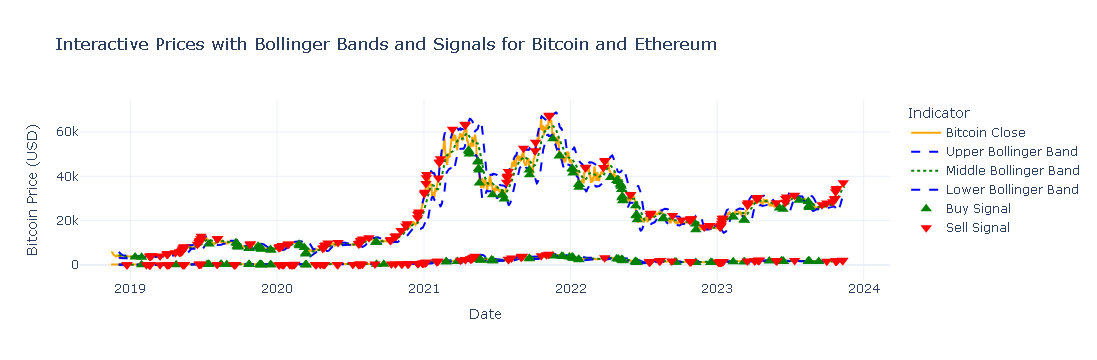

In [38]:
import plotly.graph_objs as go

# Create a Plotly figure
fig = go.Figure()

# Bitcoin traces
fig.add_trace(go.Scatter(x=bitcoin_data['Date'], y=bitcoin_data['Close'], mode='lines', name='Bitcoin Close', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=bitcoin_data['Date'], y=bitcoin_data['bb_upper'], mode='lines', name='Upper Bollinger Band', line=dict(color='blue', dash='dash')))
fig.add_trace(go.Scatter(x=bitcoin_data['Date'], y=bitcoin_data['bb_mid'], mode='lines', name='Middle Bollinger Band', line=dict(color='green', dash='dot')))
fig.add_trace(go.Scatter(x=bitcoin_data['Date'], y=bitcoin_data['bb_lower'], mode='lines', name='Lower Bollinger Band', line=dict(color='blue', dash='dash')))
fig.add_trace(go.Scatter(x=bitcoin_data['Date'][bitcoin_data['Buy_Signal'] == 1], y=bitcoin_data['Close'][bitcoin_data['Buy_Signal'] == 1], mode='markers', name='Buy Signal', marker=dict(color='green', size=10, symbol='triangle-up')))
fig.add_trace(go.Scatter(x=bitcoin_data['Date'][bitcoin_data['Sell_Signal'] == 1], y=bitcoin_data['Close'][bitcoin_data['Sell_Signal'] == 1], mode='markers', name='Sell Signal', marker=dict(color='red', size=10, symbol='triangle-down')))

# Ethereum traces
fig.add_trace(go.Scatter(x=ethereum_data['Date'], y=ethereum_data['Close'], mode='lines', name='Ethereum Close', line=dict(color='orange'), showlegend=False))
fig.add_trace(go.Scatter(x=ethereum_data['Date'], y=ethereum_data['bb_upper'], mode='lines', name='Upper Bollinger Band', line=dict(color='blue', dash='dash'), showlegend=False))
fig.add_trace(go.Scatter(x=ethereum_data['Date'], y=ethereum_data['bb_mid'], mode='lines', name='Middle Bollinger Band', line=dict(color='green', dash='dot'), showlegend=False))
fig.add_trace(go.Scatter(x=ethereum_data['Date'], y=ethereum_data['bb_lower'], mode='lines', name='Lower Bollinger Band', line=dict(color='blue', dash='dash'), showlegend=False))
fig.add_trace(go.Scatter(x=ethereum_data['Date'][ethereum_data['Buy_Signal'] == 1], y=ethereum_data['Close'][ethereum_data['Buy_Signal'] == 1], mode='markers', name='Buy Signal', marker=dict(color='green', size=10, symbol='triangle-up'), showlegend=False))
fig.add_trace(go.Scatter(x=ethereum_data['Date'][ethereum_data['Sell_Signal'] == 1], y=ethereum_data['Close'][ethereum_data['Sell_Signal'] == 1], mode='markers', name='Sell Signal', marker=dict(color='red', size=10, symbol='triangle-down'), showlegend=False))

# Update layout for a cleaner look
fig.update_layout(
    title='Interactive Prices with Bollinger Bands and Signals for Bitcoin and Ethereum',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend_title='Indicator',
    template='plotly_white'
)

# Adding a second y-axis for the Ethereum chart
fig.update_layout(
    xaxis=dict(domain=[0, 1]),
    yaxis=dict(title='Bitcoin Price (USD)'),
    yaxis2=dict(title='Ethereum Price (USD)', overlaying='y', side='right')
)

# Show the plot
fig.show()


# Prophet

20:21:18 - cmdstanpy - INFO - Chain [1] start processing
20:21:20 - cmdstanpy - INFO - Chain [1] done processing


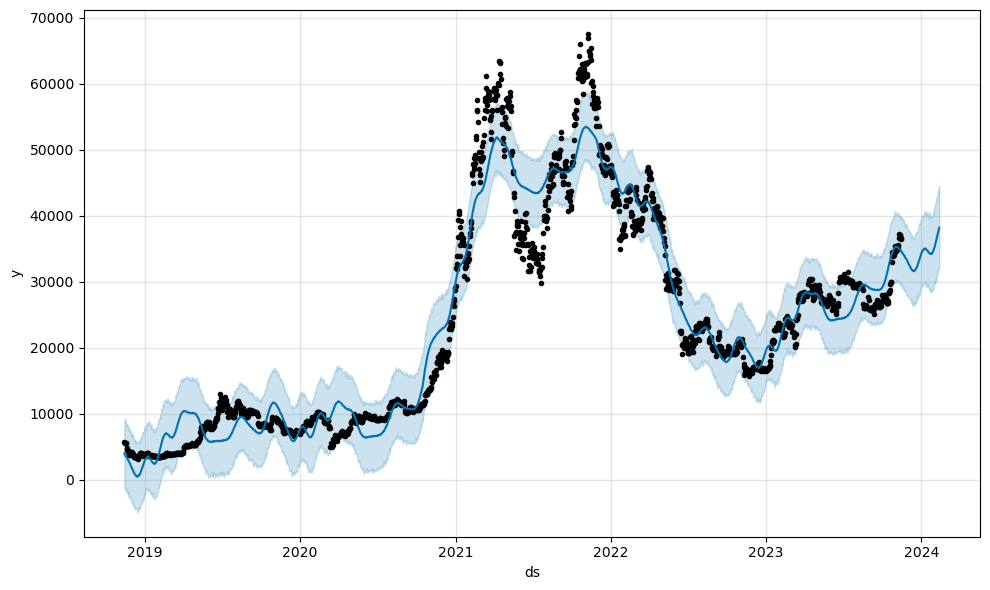

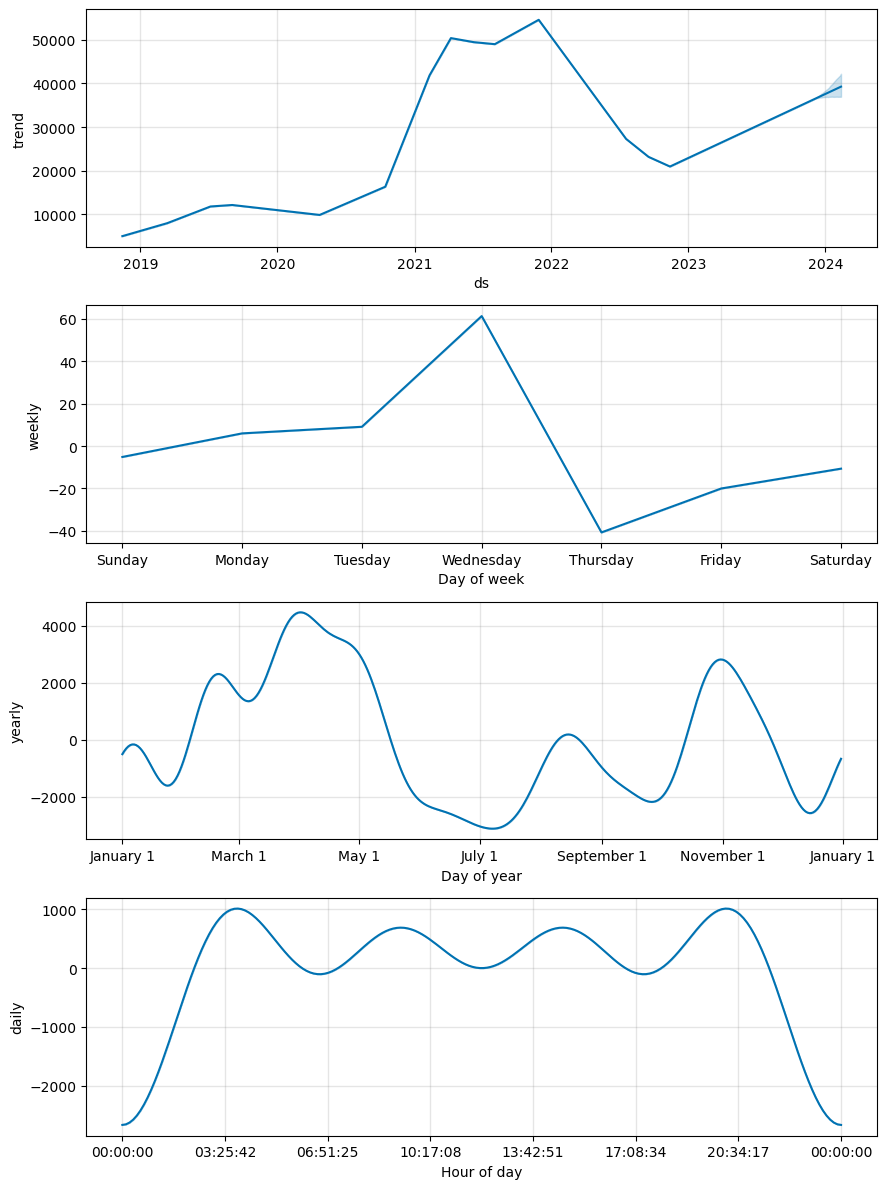

In [41]:
from prophet import Prophet
import pandas as pd

bitcoin_data.reset_index(inplace=True)  # Resetting index if 'Date' is the index

# Prepare the DataFrame for Prophet
df_prophet = pd.DataFrame({
    'ds': bitcoin_data['Date'],  # Prophet expects the date column named as 'ds'
    'y': bitcoin_data['Close']   # Prophet expects the target variable column named as 'y'
})

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Create future dataframe and forecast
future = model.make_future_dataframe(periods=90)  # Extend the dataframe to include future dates for forecasting
forecast = model.predict(future)

# Plotting the forecast
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)


In [43]:
# Import necessary libraries
from prophet import Prophet
import pandas as pd

# Load your data into 'bitcoin_data' DataFrame
# bitcoin_data = pd.read_csv('path_to_your_data.csv')  # Uncomment this line if you need to load data from a CSV file

# Ensure the 'Date' column is in the proper datetime format and sort the DataFrame by date
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
bitcoin_data.sort_values('Date', inplace=True)

# Reset index if 'Date' is the index
bitcoin_data.reset_index(drop=True, inplace=True)

# Split the data into training and testing sets (e.g., last 90 days as test data)
split_point = len(bitcoin_data) - 90
train_data = bitcoin_data[:split_point]
test_data = bitcoin_data[split_point:]

# Prepare the DataFrame for Prophet
df_train = pd.DataFrame({
    'ds': train_data['Date'],
    'y': train_data['Close']
})


In [44]:
# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(df_train)


20:31:24 - cmdstanpy - INFO - Chain [1] start processing
20:31:25 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# Prepare the future DataFrame for forecasting, including both training and test periods
future = model.make_future_dataframe(periods=90)  # '90' should match the length of your test set
forecast = model.predict(future)

# Focus on the test period
forecast_test = forecast[-90:]  # Adjust the slice according to your test set size


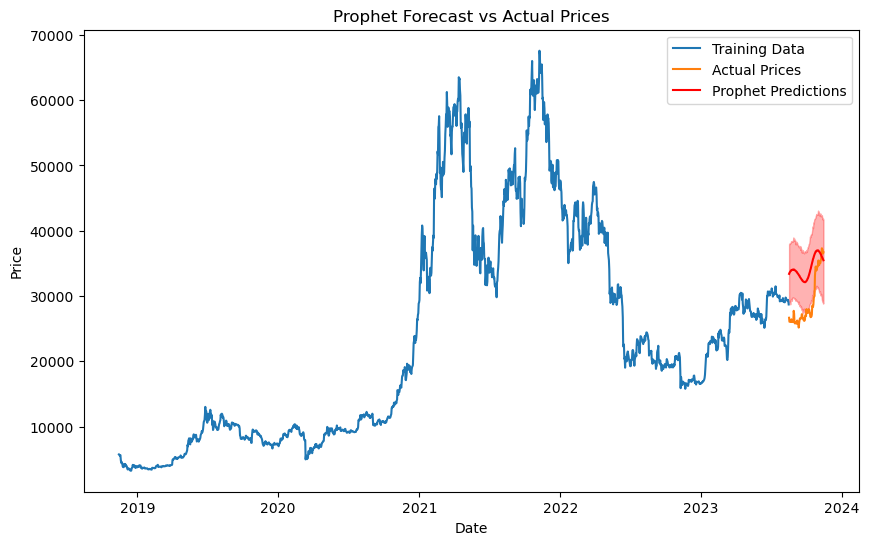

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_data['Date'], train_data['Close'], label='Training Data')
ax.plot(test_data['Date'], test_data['Close'], label='Actual Prices')
ax.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Predictions', color='red')
ax.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='red', alpha=0.3)
ax.set_title('Prophet Forecast vs Actual Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
plt.show()


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate MSE and MAE
mse = mean_squared_error(test_data['Close'], forecast_test['yhat'])
mae = mean_absolute_error(test_data['Close'], forecast_test['yhat'])

# Display the metrics
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 35099135.24510359
Mean Absolute Error: 5445.5811548170595


Epoch 1/100
46/46 - 4s - 82ms/step - loss: 0.0450
Epoch 2/100
46/46 - 0s - 3ms/step - loss: 0.0022
Epoch 3/100
46/46 - 0s - 3ms/step - loss: 0.0017
Epoch 4/100
46/46 - 0s - 3ms/step - loss: 0.0015
Epoch 5/100
46/46 - 0s - 3ms/step - loss: 0.0014
Epoch 6/100
46/46 - 0s - 2ms/step - loss: 0.0013
Epoch 7/100
46/46 - 0s - 3ms/step - loss: 0.0012
Epoch 8/100
46/46 - 0s - 2ms/step - loss: 0.0011
Epoch 9/100
46/46 - 0s - 3ms/step - loss: 0.0011
Epoch 10/100
46/46 - 0s - 3ms/step - loss: 0.0011
Epoch 11/100
46/46 - 0s - 2ms/step - loss: 0.0010
Epoch 12/100
46/46 - 0s - 2ms/step - loss: 9.8607e-04
Epoch 13/100
46/46 - 0s - 2ms/step - loss: 9.4111e-04
Epoch 14/100
46/46 - 0s - 3ms/step - loss: 9.0840e-04
Epoch 15/100
46/46 - 0s - 2ms/step - loss: 8.8538e-04
Epoch 16/100
46/46 - 0s - 3ms/step - loss: 9.1495e-04
Epoch 17/100
46/46 - 0s - 3ms/step - loss: 8.2320e-04
Epoch 18/100
46/46 - 0s - 3ms/step - loss: 7.8861e-04
Epoch 19/100
46/46 - 0s - 3ms/step - loss: 7.5678e-04
Epoch 20/100
46/46 - 0s - 

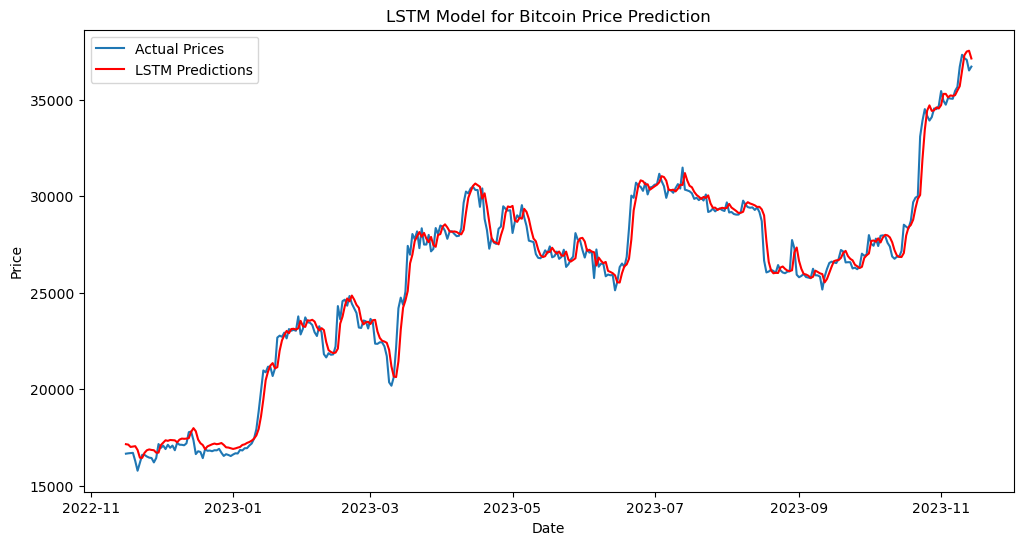

In [50]:
# Select relevant columns and set 'Date' as the index
bitcoin_data = df[df['Currency'] == 'Bitcoin'][['Date', 'Close']].set_index('Date')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data)

# Prepare the data for LSTM
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 10  # Adjust as needed
X, y = create_dataset(scaled_data, time_steps)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = y[:train_size], y[train_size:]

# Reshape the input data for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, time_steps), activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2)

# Make predictions on the test set
predictions = model.predict(testX)
predictions = scaler.inverse_transform(predictions)

# Invert the scaling for the actual values
actual_values = scaler.inverse_transform([testY])

# Evaluate the model
mse = mean_squared_error(actual_values[0], predictions[:, 0])
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data.index[train_size+time_steps:], actual_values[0], label='Actual Prices')
plt.plot(bitcoin_data.index[train_size+time_steps:], predictions[:, 0], label='LSTM Predictions', color='red')
plt.title('LSTM Model for Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()